dependencies

In [2]:
# !python -m spacy download nb_core_news_sm
# !python -m spacy download nb_core_news_md
# !python -m spacy download nb_core_news_lg
# !pip install sklearn
# !pip install spacy
# !pip install json
# !pip install seaborn
# !pip install gitpython

download files used later

In [3]:
from git import Repo
from os import curdir

# repo = Repo.clone_from('https://github.com/ltgoslo/norec_sentence.git', curdir+'/norec_sentence')

In [4]:
import spacy
import pandas
from time import time
from IPython.display import clear_output
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [5]:
import json
data_3class = {}
for name in ["train", "dev", "test"]:
    with open(f"norec_sentence/3class/{name}.json") as infile:
        data_3class[name] = json.load(infile)

Oure data is orginized so that train, test and dev all include text, lables and sent_id so we re orginize the data. With two dictionaries including train-dev-test we can utilize oure text and lable data with shorter lines of code 

In [6]:
text = {'train': [x['text'] for x in data_3class['train']], 
        'dev' : [x['text'] for x in data_3class['dev']],
        'test':[x['text'] for x in data_3class['test']]}

labels ={'train':[x['label'] for x in data_3class['train']],
         'dev' : [x['label'] for x in data_3class['dev']],
         'test':[x['label'] for x in data_3class['test']]}

custom lemmatizer that lowers every sentence and the uses a spacy model to turn each word into it's lemma if the word is not in the stopword list

In [7]:
def lemmatizer(list_sentc:list, nlp:spacy, stop:bool)->list:
    """takes a list of sentences and returns a list of lemmatized sentences using the lemma_ 
    atribute from spacy, and list comprehention to filter out stopwords

    Args:
        list_sentc (list): a list of multiword sentences
        nlp (spacy): a spacy language model for lemmatization
        stop (bool): if true includes stopwords, if false removes stopwords
        
    Returns:
        list: lemmatized sentences
    """
    result = []
    for sentence in list_sentc:
        if nlp != None:
            # runs stopwords thoruhg spacy
            doc = nlp(sentence.lower())
            if stop == False:
                result.append(' '.join([token.lemma_ for token in doc if token.is_stop is False]))
            else:
                result.append(' '.join([token.lemma_ for token in doc]))
        else:
            nlp = spacy.load('nb_core_news_sm')
            doc = nlp(sentence.lower())
            if stop == False:
                result.append(' '.join([token.text for token in doc if token.is_stop is False]))
            else:
                result.append(sentence)

    return result

the spacy language models that are compatible with oure lemmatizer function

In [8]:
nb_nlp = {'none': None, 'small': spacy.load('nb_core_news_sm'), 'medium': spacy.load('nb_core_news_md'), 'large':spacy.load('nb_core_news_lg')}

In [9]:
# fits text to a vector and then makes document count matricees for each 
# combination fo lemmatization model and if stopwords should be removed

text_comb = text['train'] + text['test'] + text['dev']

vectorizer = CountVectorizer()
vectorizer.fit(text_comb)

grid = {}
for nlp in nb_nlp:    
    for stop in [True, False]:
        sentences = lemmatizer(text_comb, nb_nlp[nlp], stop)

        grid[f'{stop}-{nlp}'] = vectorizer.transform(sentences).toarray()


**make barplott**

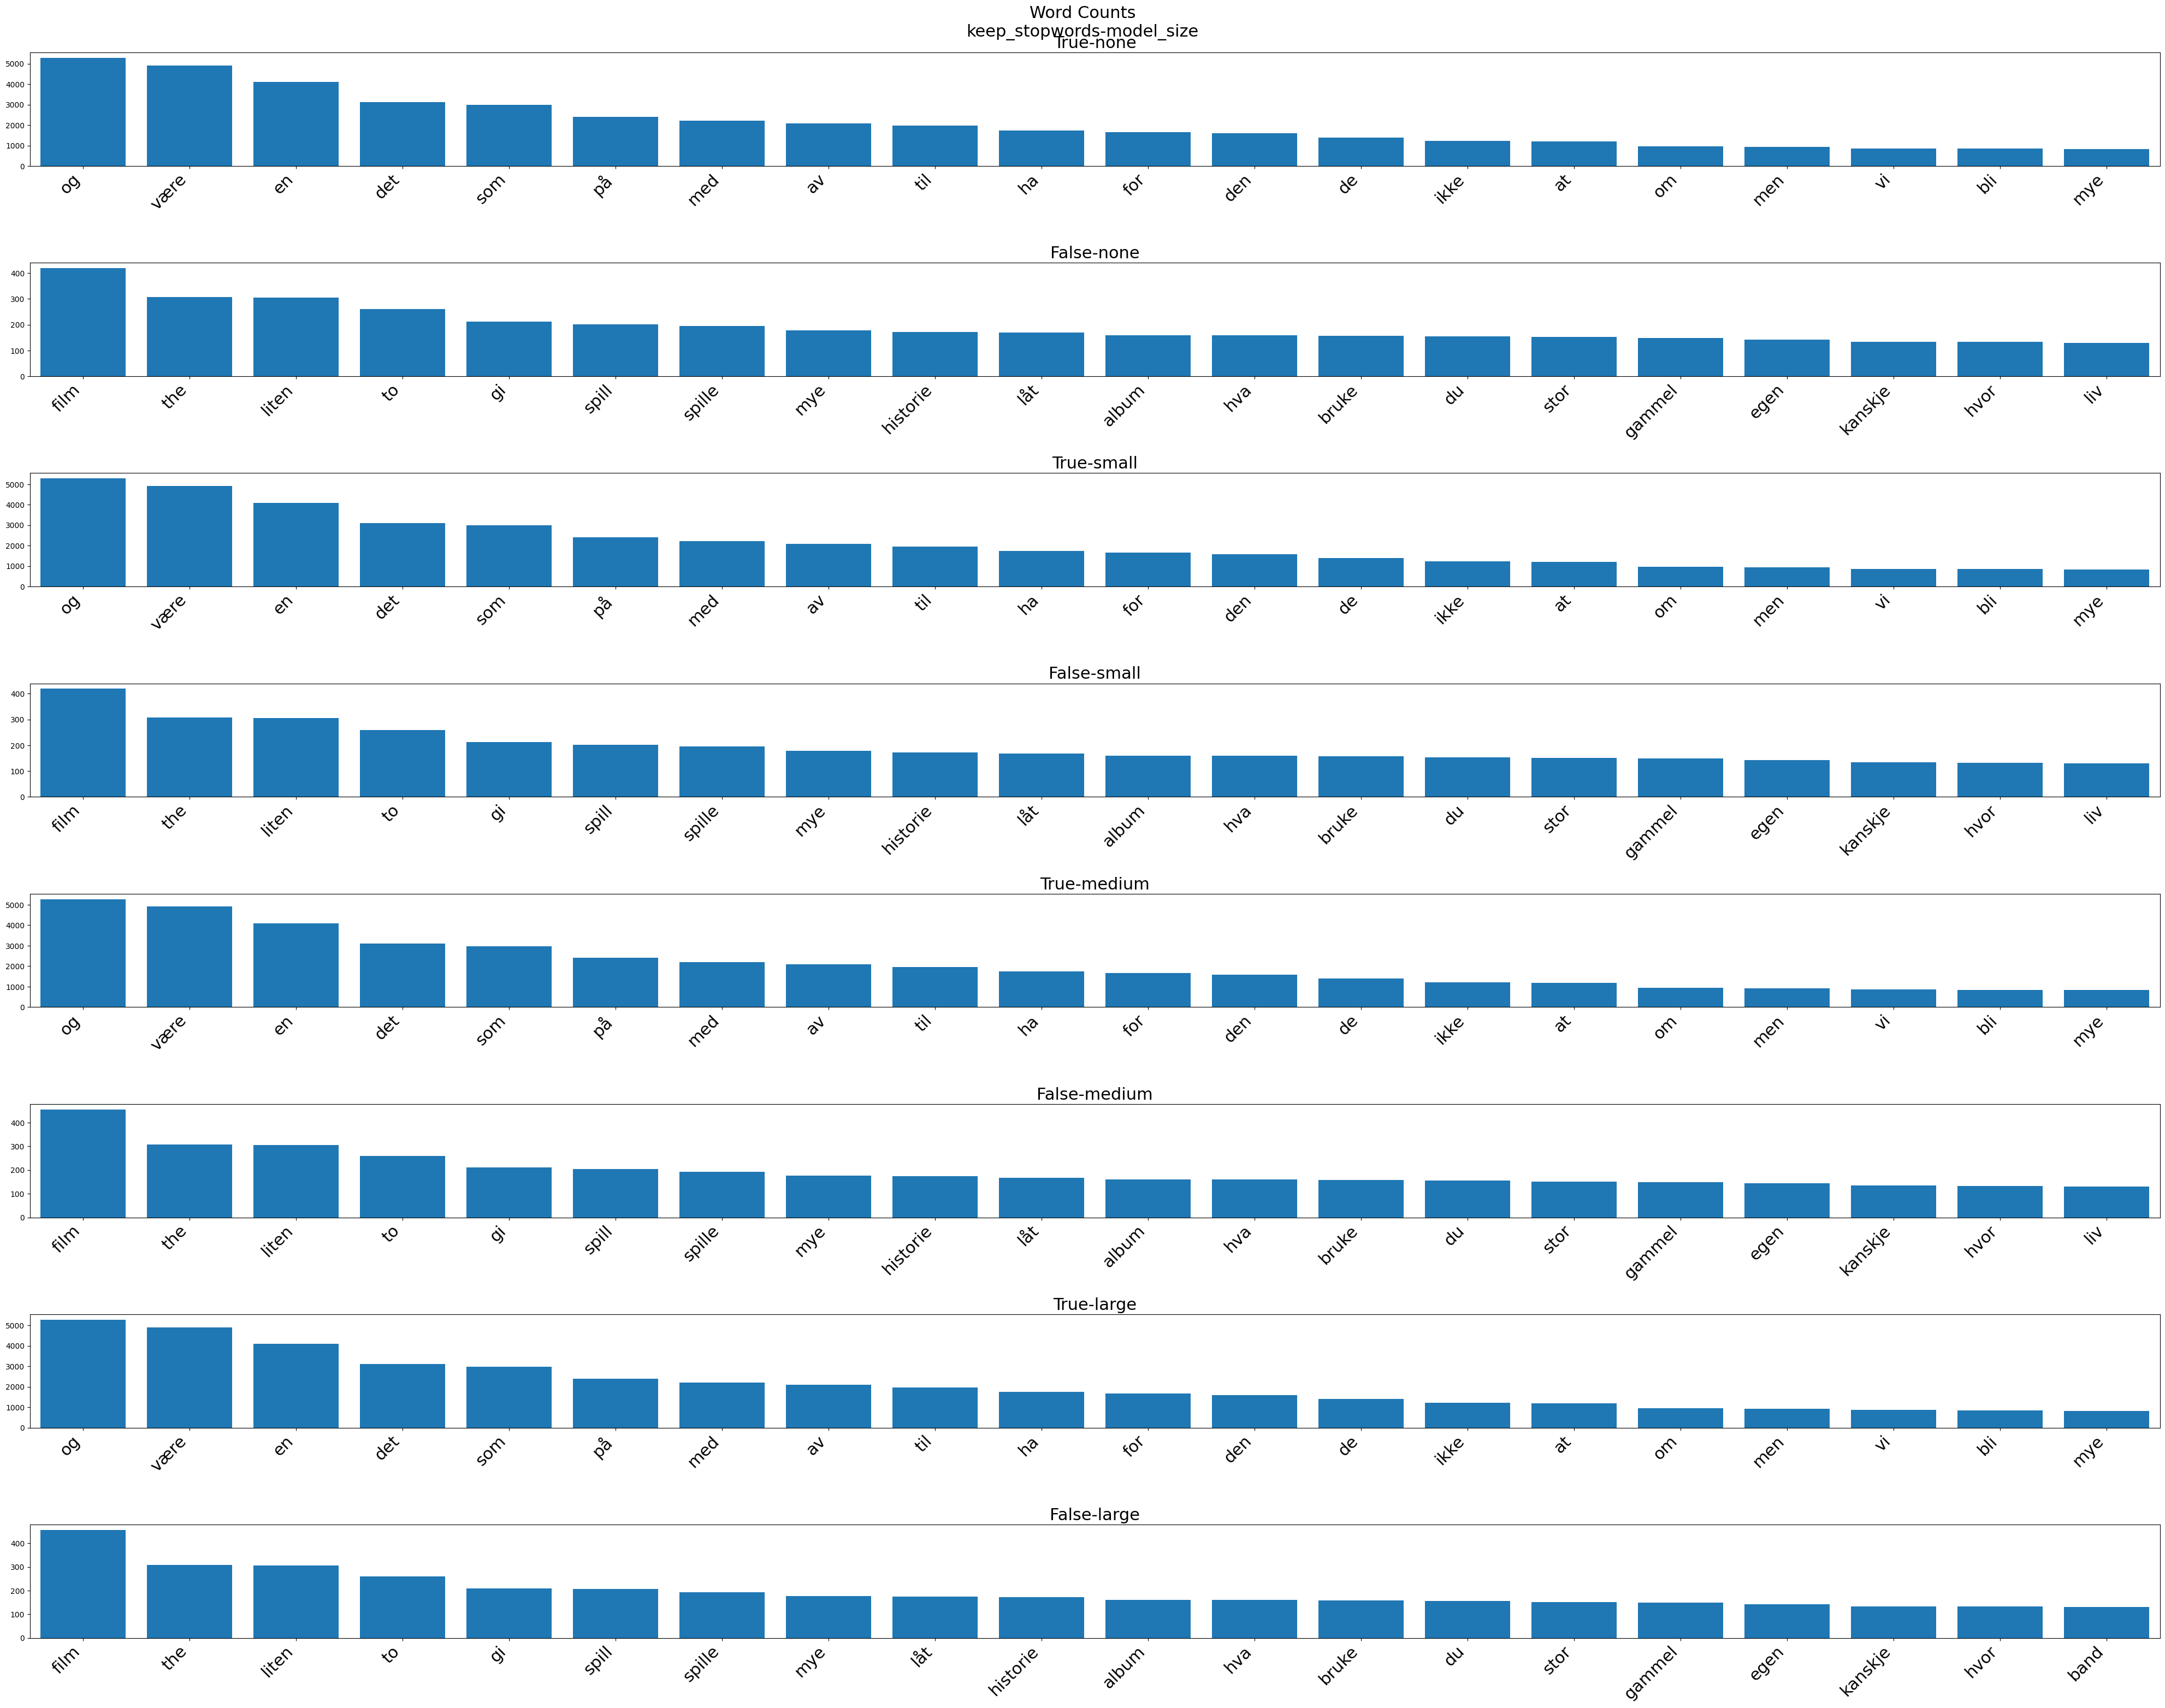

In [15]:
import matplotlib.pyplot as plt

arrays = [x[1] for x in grid.items()]
keys = [x for x in grid.keys()]

# get the unique words that were counted
words = vectorizer.get_feature_names_out()

# create a 2x2 grid of plots
fig, axs = plt.subplots(8, 1, figsize=(40, 32))

# create a bar chart for each list of sentences in each subplot
for i, counts in enumerate(arrays):
    ax = axs[i]  # get the current subplot
    sorted_counts = sorted(zip(words, counts.sum(axis=0)), key=lambda x: -x[1])
    top_words = [w[0] for w in sorted_counts[:20]]
    top_counts = [w[1] for w in sorted_counts[:20]]
    ax.bar(top_words, top_counts)  # create a bar chart in the current subplot
    ax.set_title(keys[i], fontsize=22)  # set the title for the current subplot
    ax.tick_params(axis='x', rotation=45, labelsize=22)  # rotate the x-axis labels for readability
    ax.set_xlim([-0.5, 19.5])  # adjust the x-axis limit to include all the bars
    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment('right')  # align the labels to the right
        tick.set_x(-0.25)  # shift the labels to the left by 0.25 units


# remove the unused subplot
if len(arrays) < 4:
    axs[-1, -1].axis('off')

# add a global title and show the plot
fig.suptitle('Word Counts\nkeep_stopwords-model_size', fontsize=22)
fig.subplots_adjust(top=0.9)
fig.tight_layout(pad=2.0)
plt.show()

Through testing with gridsearch and multiple parameters we found that Support Vector-Machines Classifier outperformed other estimators on our dataset. 

To find the optimal parameters for SVC we used a pipeline and grid-search to look for hyper parameters, though we did not test for lemmatization parameters with grid-search and instead made a simplistic grid in python, in testing we tried making a class that would be usable with the pipeline and grid-search but failed ass there were a lot of comparability issues, so in the interest of time we moved on. Though it is possible to make a custom class that works with the pipeline and grid-search in sklearn and here a good guide: https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156?gi=8d6de1529edc.

There are two ways of vectorizing text data, CountVectorizer and TfidfVectorizer, a not so obvious detail is that TfidfVectorizer has a variable "use_idf" that when set to False makes it perform count vectorization in stead. We chose TfidfVectorizer so that we could test what type of vectorization would give the best performance in our gridsearch.

our lemmatizer removes at most about 20% of the complexity. this seems like a small amount as words usually have multiple forms, but when looking into the text data we see that there are a lot of numbers and words that are not Norwegian, these can be model numbers and brand names and can therefore be important for the sentiment analysis. but we can remove unimportant words by limiting the minimum document frequency.

In [14]:
# since gridsearchCV splits data in the cros validation prosess 
# we combine it on the beforehand so that we get the moste preccise score
text_comb = text['train'] + text['test'] + text['dev']
labels_comb = labels['train'] + labels['test'] + labels['dev']

In [ ]:
def prim_grid(pipe, params, text, labels):

    result = {}
    i = 0
    times = []

    # we itterate trough language models and lists of stopwords so that we can make a dictionary of results.
    # and we print the progress of oure search
    for model in nb_nlp:
        for stop_bool in [True, False]:
            # records the current time since inception in seconds
            start = time()

            text = lemmatizer(text, nb_nlp[model], stop=stop_bool)
            grid = GridSearchCV(pipe, params, n_jobs=-1)
            grid.fit(text, labels)

            score = grid.best_score_

            result[score] = grid.best_params_
            result[score]['lemm__models'] = model
            result[score]['lemm__stop'] = stop_bool

            stop = time()

            # adds the running time to times list
            times.append(stop-start)

            i += 1

            #find the average time
            time_left_s = ((len(nb_nlp)*2)-i)*(sum(times)/len(times))
            
            # translate time to hours minuts and seconds
            if time_left_s < 60.0:
                time_left = f'{round(time_left_s)} seconds'
            else:
                if time_left_s < 3600.0:
                    time_left_m = round(time_left_s/60)
                    time_left_s = round(time_left_s%60)
                    time_left = f'{time_left_m} minuts and {time_left_s} seconds'
                else:
                    time_left_h = round(time_left_s/3600)
                    time_left_m = round((time_left_s%3600)/60)
                    time_left_s = round((time_left_s%3600)%60)
                    time_left = f'{time_left_h} hours, {time_left_m} minuts and {time_left_s} seconds'

            clear_output(wait=True)
            print('progress')
            print(f'{(i/(len(nb_nlp)*2))*100}% \nestimated time left: {time_left}')

    return result

In [32]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('clf', SVC())])

params = {'clf__C': [0.001, 1, 1000],
          'clf__gamma': [0.1, 1, 10],
          'vect__ngram_range': [(1,1), (1,2), (1,3)],
          'vect__use_idf': [True, False],
          'vect__min_df': [0, 1, 2, 3]}

result = prim_grid(pipe, params, text_comb, labels_comb)

progress
12.5% 
estimated time left: 8 hours, 53 minuts and 46 seconds


KeyboardInterrupt: 

these are the optimal parameters from a 10 houre parameter search

In [17]:
max_score = max(result.keys())
print(f'score:{max_score} \nparameters:{result[max_score]}')

score:0.6434453383814482 
parameters:{'clf__C': 1000, 'clf__gamma': 1, 'vect__min_df': 2, 'vect__ngram_range': (1, 1), 'vect__use_idf': True, 'lemm__models': 'medium', 'lemm__stop': True}


average accuracy; 0.6435152374202693
f1 weighted score: 0.6283201453029899
Axes(0.125,0.11;0.62x0.77)


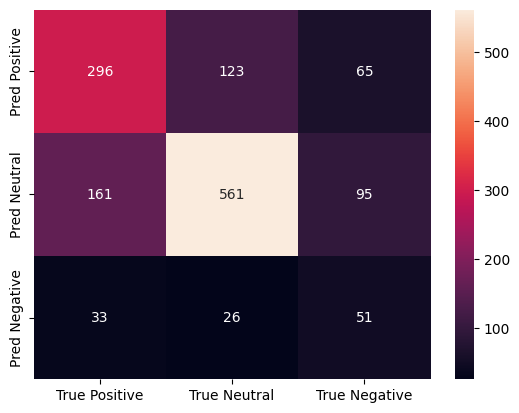

In [18]:
from seaborn import heatmap
from sklearn.metrics import f1_score
pipe = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,1), min_df=2, use_idf=True)),
                 ('clf', SVC(C=1000, gamma=1))])

x_train = text['train']+text['test']
x_train = lemmatizer(x_train, nb_nlp['medium'], True)
x_test = text['dev']
x_test = lemmatizer(x_test, nb_nlp['medium'], True)
y_train = labels['train']+labels['test']
y_test = labels['dev']

pipe.fit(x_train, y_train)

prediction = pipe.predict(x_test)

cnf_mtrx = confusion_matrix(prediction, y_test, labels = ['Positive', 'Neutral', 'Negative'])

matrix = pandas.DataFrame(cnf_mtrx, index = ['Pred Positive', 'Pred Neutral', 'Pred Negative'], columns = ['True Positive', 'True Neutral', 'True Negative'])

print('average accuracy;', pipe.score(x_test, y_test))
print('f1 weighted score:', f1_score(y_test, prediction, average='weighted'))
print(heatmap(matrix, annot=True, fmt='d'))

Researchers have found that humans agree on the sentiment of a sentence about 80-85% of the time (https://mashable.com/archive/sentiment-analysis), meaning that if for example our model gets an accuracy of 100% then from a humans perspective it would still only be about 80% accurate, this also means that the data is inconsistently labelled since about 20% of the labels are disputable, so we should accept accuracies of around 80% as being "ass good as it gets". 
source:  
Sentiment Analysis: High-impact Strategies - What You Need to Know: Definitions, Adoptions, Impact, Benefits, Maturity, Vendors

the resulting accuracy is at 64% which seems low, and could probably be higher with more training data, but as we see in the confusion matrix our main problem is the amount of negative labels, there are so few sentences with a negative label that the model struggles at predicting them accurately.

In [19]:
print(f'Number of positive sentiments:{len([x for x in labels_comb if x=="Positive"])}')
print(f'Number of neutral sentiments:{len([x for x in labels_comb if x=="Neutral"])}')
print(f'Number of negative sentiments:{len([x for x in labels_comb if x=="Negative"])}')

Number of positive sentiments:3515
Number of neutral sentiments:5387
Number of negative sentiments:1663


since the model is biased towards neutral data we try to do gridsearch with balanced data and train a new modell

grid search with balanced data

In [20]:
bal_text_comb = []
bal_label_comb = []
n_positive = 0
n_neutral = 0
n_negative = 0

# ballance by looking for lables, 
# adding corresponding text and labels to a list 
# and count different types of labels

for index in range(0, len(labels_comb)):
    label = labels_comb[index]
    match label:
        case 'Positive':
            if n_positive < 1663:
                bal_text_comb.append(text_comb[index])
                bal_label_comb.append(labels_comb[index])
                n_positive += 1
        
        case 'Neutral':
            if n_neutral < 1663:
                bal_text_comb.append(text_comb[index])
                bal_label_comb.append(labels_comb[index])
                n_neutral += 1
        
        case 'Negative':
            if n_negative < 1663:
                bal_text_comb.append(text_comb[index])
                bal_label_comb.append(labels_comb[index])
                n_negative += 1

In [21]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('clf', SVC())])

params = {'clf__C': [0.001, 1, 1000],
          'clf__gamma': [0.1, 1, 10],
          'vect__ngram_range': [(1,1), (1,2), (1,3)],
          'vect__use_idf': [True, False],
          'vect__min_df': [0, 1, 2, 3]}

result = prim_grid(pipe, params, bal_text_comb, bal_label_comb)

progress
66.66666666666666% 
estimated time left: 48.02491105000178 minuts and 1.4946630001068115 seconds


In [22]:
max_score = max(result.keys())
print(f'score:{max_score} \nparameters:{result[max_score]}')

score:0.5488079468867525 
parameters:{'clf__C': 1, 'clf__gamma': 1, 'vect__min_df': 3, 'vect__ngram_range': (1, 1), 'vect__use_idf': False, 'lemm__models': 'medium', 'lemm__stop': True}


training with new parameters optimized for balanced data

average accuracy; 0.5414599574769667
f1 weighted score: 0.5567911011964015
Axes(0.125,0.11;0.62x0.77)


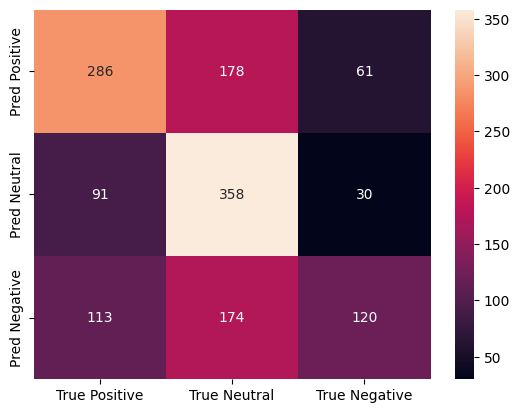

In [19]:
pipe2 = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,1), min_df=3, use_idf=False)),
                 ('clf', SVC(C=1, gamma=1))])

bal_x_train = []
bal_y_train = []
x_train = text['train']+text['test']
x_train = lemmatizer(x_train, nb_nlp['medium'], True)
y_train = labels['train']+labels['test']

n_positive = 0
n_neutral = 0
n_negative = 0

for index in range(0, len(labels_comb)):
    label = labels_comb[index]
    match label:
        case 'Positive':
            if n_positive < 1452:
                bal_x_train.append(x_train[index])
                bal_y_train.append(y_train[index])
                n_positive += 1
        
        case 'Neutral':
            if n_neutral < 1452:
                bal_x_train.append(x_train[index])
                bal_y_train.append(y_train[index])
                n_neutral += 1
        
        case 'Negative':
            if n_negative < 1452:
                bal_x_train.append(x_train[index])
                bal_y_train.append(y_train[index])
                n_negative += 1


x_test = text['dev']
x_test = lemmatizer(x_test, nb_nlp['medium'], True)
y_test = labels['dev']

pipe2.fit(bal_x_train, bal_y_train)

prediction = pipe2.predict(x_test)

cnf_mtrx = confusion_matrix(prediction, y_test, labels = ['Positive', 'Neutral', 'Negative'])

matrix = pandas.DataFrame(cnf_mtrx, index = ['Pred Positive', 'Pred Neutral', 'Pred Negative'], columns = ['True Positive', 'True Neutral', 'True Negative'])

print('average accuracy;', pipe2.score(x_test, y_test))
print('f1 weighted score:', f1_score(y_test, prediction, average='weighted'))
print(heatmap(matrix, annot=True, fmt='d'))

while we get better at predicting negative labels it comes at the cost of lowering oure overall accuracy from 64% to 53%, and even though the f1 weighted score is higher than average accuracy but lower than the model traine on the unbalanced data

In [15]:
pipe = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,1), min_df=2, use_idf=True)),
                 ('clf', SVC(C=1000, gamma=1))])

pipe.fit(text_comb, labels_comb)

Pipeline(steps=[('vect', TfidfVectorizer(min_df=2)),
                ('clf', SVC(C=1000, gamma=1))])

In [16]:
def pred_n_return(pipe:Pipeline, nlp:spacy, stop:bool, sentences:list=[]):
    """tries to predict the sentiment of a list of senteces if a list of sentences is given, 
    else it prompts for sentence until told to stop

    Args:
        pipe (Pipeline): a sklearn pipeline
        nlp (spacy): a language model
        stop (bool): if stopword removal should be implemented or not
        sentences (list): list of sentences that is empty by defaul
    """
    sent = ''
    if sentences==[]:
        while sent != ['stop']:
            sent = [input("Type 'stop' to stop \nType a sentence in norwegian:")]
            sent = lemmatizer(sent, nlp, stop)
            result = pipe.predict(sent)
            print(f"the sentence is {result[0]}")
    else:
        sent = lemmatizer(sentences, nlp, stop)
        result = pipe.predict(sent)
        for i in range(0, len(result)):
            print(sentences[i], 'is:', result[i])

Underneath we have made a function so that you can test the prediction power of our model on Norwegian sentences

In [21]:
pred_n_return(pipe, nb_nlp['medium'], True)

the sentence is Positive
the sentence is Neutral


stopwords sourced from:  
https://searchcode.com/file/257516021/data/stopwords/stopwords-nb.txt/  
https://raw.githubusercontent.com/stopwords-iso/stopwords-no/master/stopwords-no.json

Dataset cloned from github: https://github.com/ltgoslo/norec_sentence

Kutuzov, A., Barnes, J., Velldal, E., Øvrelid, L., & Oepen, S. (2021). Large-Scale Contextualised Language Modelling for Norwegian. Proceedings of the 23rd Nordic Conference on Computational Linguistics (NoDaLiDa 2021).

Øvrelid, L., Mæhlum, P., Barnes, J., & Velldal, E. (2020). A Fine-grained Sentiment Dataset for Norwegian. Proceedings of the 12th Edition of the Language Resources and Evaluation Conference. Marseille, France, 2020.